# Expression Classification Model Training

This notebook demonstrates how to train a custom expression classification model using TensorFlow and Keras, with CUDA support for GPU acceleration. The model will classify facial expressions into 7 categories: angry, disgust, fear, happy, neutral, sad, and surprise.

## env preperation

In [19]:
# create virtual environment and use it
!python3 -m venv .venv

In [21]:
!python -m ipykernel install --user --name=.venv --display-name "Python (myenv)"

Installed kernelspec .venv in /workspace/home/user/.local/share/jupyter/kernels/.venv


In [1]:
# check the environment
import sys
sys.executable

'/opt/micromamba/envs/python_310/bin/python'

In [2]:
!pip install TensorFlow==2.12.0 Keras NumPy Matplotlib Seaborn Scikit-learn

  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 952.4 kB/s eta 0:00:00 0:00:01
  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached grpcio-1.66.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Usi

In [17]:
!nvidia-smi

Sat Aug 31 14:17:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    On  | 00000000:82:00.0 Off |                  Off |
| 30%   30C    P8               8W / 130W |      5MiB / 20475MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## librarys abd dependency calling

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import os
import random

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Device name: ", tf.config.list_physical_devices('GPU'))
print("Build With CUDA: ", tf.test.is_built_with_cuda())
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  0
Device name:  []
Build With CUDA:  True
TensorFlow version: 2.17.0


## Data Preparation and Normalization

#### dataset download (if not done)

In [ ]:
# downloading the dataset
import opendatasets as od
import threading

def download_dataset(url):
    od.download(url, force=True)

# URL for the dataset
url = "https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset"

# Create a thread for downloading the dataset
download_thread = threading.Thread(target=download_dataset, args=(url,))

# Start the download thread
download_thread.start()

# Wait for the download to complete
download_thread.join()

#### data preparation

In [34]:
# Set the path to your main data directory
data_dir = './face-expression-recognition-dataset/images/images'

# Define image parameters
img_height, img_width = 48, 48
batch_size = 150
num_classes = 7

# Create data generators with preprocessing
def preprocess_image(img):
    # Convert to grayscale if the image is RGB
    if img.shape[-1] == 3:
        img = tf.image.rgb_to_grayscale(img)
    # Ensure the image is float32
    img = tf.cast(img, tf.float32)
    # Normalize to [-1, 1]
    img = (img / 127.5) - 1
    return img

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of training data for validation
)

# Load and prepare the training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training',
    shuffle=True
)

# Load and prepare the validation data
validation_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),  # Use the same directory as training
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation',
    shuffle=False
)

# Load and prepare the test data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")
print(f"Number of classes: {num_classes}")
print(f"Class indices: {train_generator.class_indices}")

Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Number of training samples: 23060
Number of validation samples: 5761
Number of test samples: 7066
Number of classes: 7
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


#### balance the data

In [35]:
# Compute class weights to handle imbalanced dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 1.031075340934496, 1: 9.439214081047892, 2: 1.0034376223837083, 3: 0.574718373043565, 4: 0.8264640527560748, 5: 0.8337852984777814, 6: 1.2848228214842878}


## Visualize Some Training Images

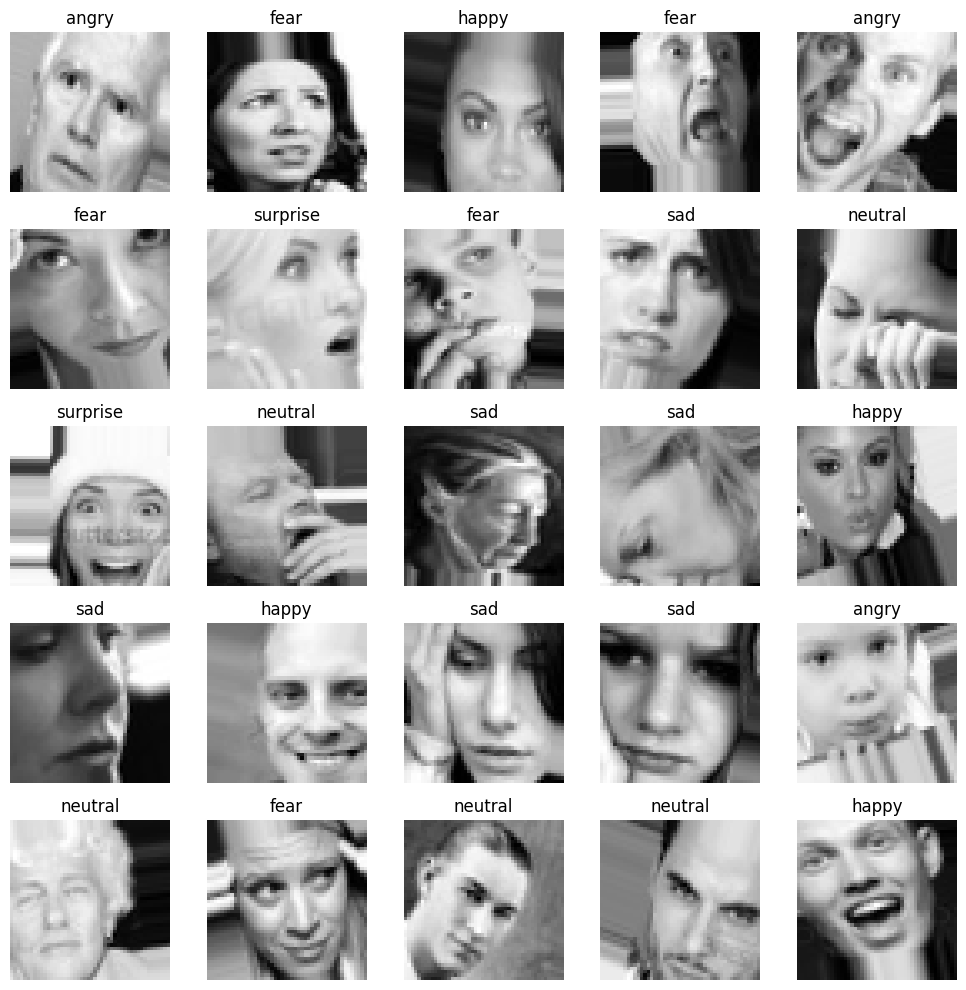

In [36]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n].reshape(img_height, img_width), cmap='gray')
        plt.title(list(train_generator.class_indices.keys())[label_batch[n].argmax()])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images and labels
image_batch, label_batch = next(iter(train_generator))

# Visualize the batch
show_batch(image_batch, label_batch)

## Model Definition

In [37]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/opt/micromamba/envs/python_310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,799 (475.78 KB)

 Trainable params: 121,799 (475.78 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [38]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Compile the model with the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('img_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model with optimizations
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weight_dict,
)

Epoch 1/100


/opt/micromamba/envs/python_310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 120s 752ms/step - accuracy: 0.1589 - loss: 1.9526 - val_accuracy: 0.1944 - val_loss: 1.9066 - learning_rate: 0.0010
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1800 - loss: 1.7691 - val_accuracy: 0.6230 - val_loss: 1.8711 - learning_rate: 0.0010
Epoch 3/100


/opt/micromamba/envs/python_310/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-08-30 23:51:06.280386: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


153/153 ━━━━━━━━━━━━━━━━━━━━ 117s 745ms/step - accuracy: 0.1898 - loss: 1.9271 - val_accuracy: 0.2139 - val_loss: 1.8814 - learning_rate: 0.0010
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2067 - loss: 1.9438 - val_accuracy: 0.7869 - val_loss: 1.3958 - learning_rate: 0.0010
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 115s 731ms/step - accuracy: 0.2062 - loss: 1.8705 - val_accuracy: 0.2249 - val_loss: 1.8363 - learning_rate: 0.0010
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1800 - loss: 1.7328 - val_accuracy: 0.6885 - val_loss: 1.4695 - learning_rate: 0.0010
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 115s 730ms/step - accuracy: 0.2130 - loss: 1.8516 - val_accuracy: 0.2475 - val_loss: 1.8152 - learning_rate: 0.0010
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.2400 - loss: 2.1390 - val_accuracy: 0.7049 - val_loss: 1.4813 - learning_rate: 0.0010
Epoch 9/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 114s 724ms/step - accuracy: 0.2103 - lo

2024-08-30 23:58:48.741087: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


153/153 ━━━━━━━━━━━━━━━━━━━━ 120s 760ms/step - accuracy: 0.2077 - loss: 1.8052 - val_accuracy: 0.2600 - val_loss: 1.7938 - learning_rate: 2.0000e-04
Epoch 12/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2533 - loss: 2.2269 - val_accuracy: 0.8361 - val_loss: 1.0301 - learning_rate: 2.0000e-04
Epoch 13/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 120s 763ms/step - accuracy: 0.2460 - loss: 1.7724 - val_accuracy: 0.2667 - val_loss: 1.7924 - learning_rate: 2.0000e-04
Epoch 14/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2667 - loss: 1.5989 - val_accuracy: 0.7213 - val_loss: 1.1468 - learning_rate: 2.0000e-04
Epoch 15/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 119s 754ms/step - accuracy: 0.2441 - loss: 1.7603 - val_accuracy: 0.2635 - val_loss: 1.7737 - learning_rate: 2.0000e-04
Epoch 16/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2267 - loss: 1.7200 - val_accuracy: 0.7049 - val_loss: 1.4445 - learning_rate: 2.0000e-04
Epoch 17/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 117s 741ms/

2024-08-31 00:14:32.360609: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


153/153 ━━━━━━━━━━━━━━━━━━━━ 115s 726ms/step - accuracy: 0.2588 - loss: 1.7747 - val_accuracy: 0.2660 - val_loss: 1.7623 - learning_rate: 8.0000e-06
Epoch 28/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2867 - loss: 1.6004 - val_accuracy: 0.8033 - val_loss: 1.0285 - learning_rate: 8.0000e-06


## Training Results Visualization

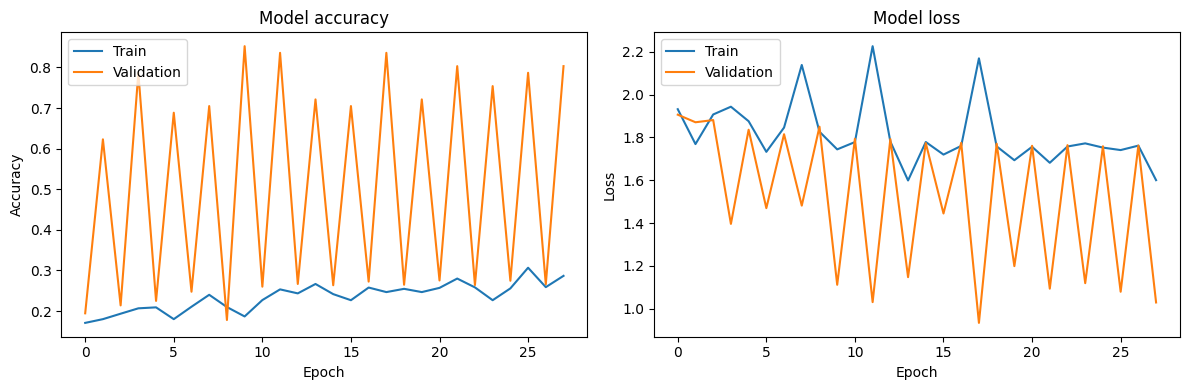

In [39]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Model Evaluation

In [40]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 746ms/step - accuracy: 0.2372 - loss: 1.8348
Test Accuracy: 0.2871
Test Loss: 1.7466


## Confusion Matrix

48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 405ms/step


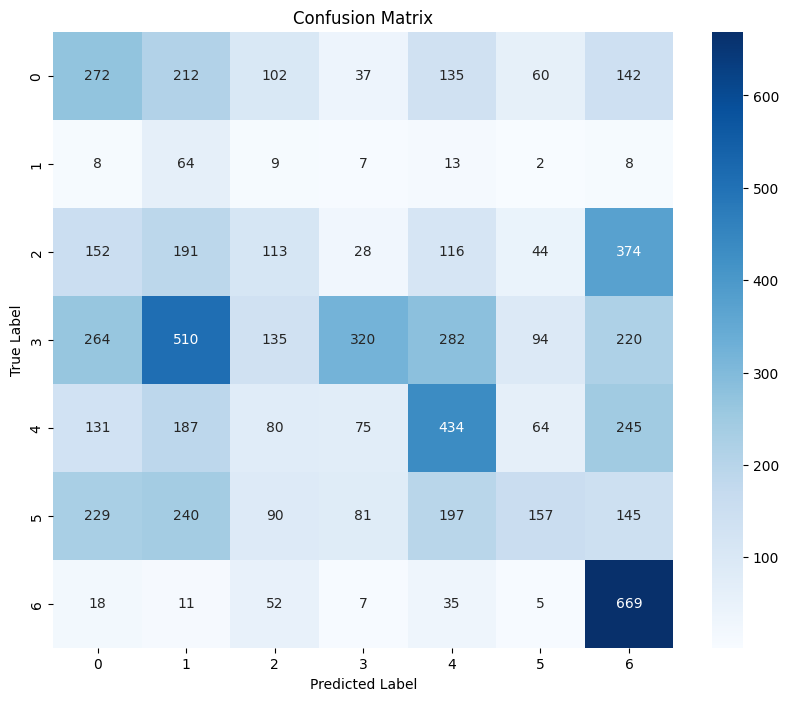

              precision    recall  f1-score   support

       angry       0.25      0.28      0.27       960
     disgust       0.05      0.58      0.08       111
        fear       0.19      0.11      0.14      1018
       happy       0.58      0.18      0.27      1825
     neutral       0.36      0.36      0.36      1216
         sad       0.37      0.14      0.20      1139
    surprise       0.37      0.84      0.51       797

    accuracy                           0.29      7066
   macro avg       0.31      0.35      0.26      7066
weighted avg       0.37      0.29      0.28      7066



In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(train_generator.class_indices.keys())))

## Try Out the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


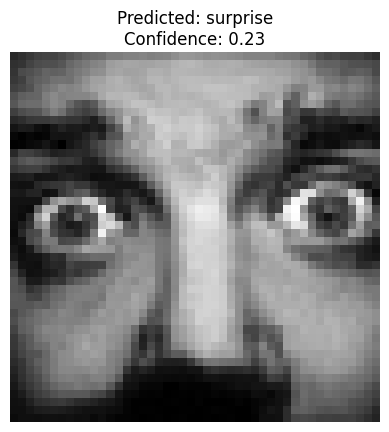

Probabilities for each class:
angry: 0.0991
disgust: 0.0945
fear: 0.1880
happy: 0.1232
neutral: 0.1753
sad: 0.0882
surprise: 0.2316


In [102]:
# Define global variables for image dimensions
img_height, img_width = 46, 46

def preprocess_image(img_array):
    # Normalize the image array
    img_array = img_array.astype('float32') / 255.0
    return img_array

def predict_expression(img_path, model, class_names):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_image(img_array)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # Make predictions
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]
    confidence = np.max(prediction)

    # Convert the image tensor to a NumPy array for visualization
    img_array_np = img_array.numpy().squeeze()  # Convert to NumPy array and remove dimensions

    # Display the image and prediction
    plt.imshow(img_array_np, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.show()

    # Print probabilities for each class
    print("Probabilities for each class:")
    for class_name, prob in zip(class_names, prediction[0]):
        print(f"{class_name}: {prob:.4f}")

# Example usage:
# Assuming you have loaded your model and class names
# model = tf.keras.models.load_model('expression_classification_model.keras')
# class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
predict_expression('./face-expression-recognition-dataset/images/images/validation/fear/10029.jpg', loaded_model, categories)


## Save the Model

In [46]:
# Save the entire model as a SavedModel
model.save('expression_classification_model.keras')
print("Model saved as 'expression_classification_model.keras'")

# Save the model architecture as JSON
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved as 'model_architecture.json'")

# Save the trained weights
model.save_weights("model.weights.h5")
print("Model weights saved as 'model.weights.h5'")

Model saved as 'expression_classification_model.keras'
Model architecture saved as 'model_architecture.json'
Model weights saved as 'model.weights.h5'


## Load and Use the Saved Model

In [89]:
# Load the saved model
loaded_model = tf.keras.models.load_model('expression_classification_model.keras')

# Verify the model architecture
loaded_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,399 (1.39 MB)

 Trainable params: 121,799 (475.78 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 243,600 (951.57 KB)

#### test with selected image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


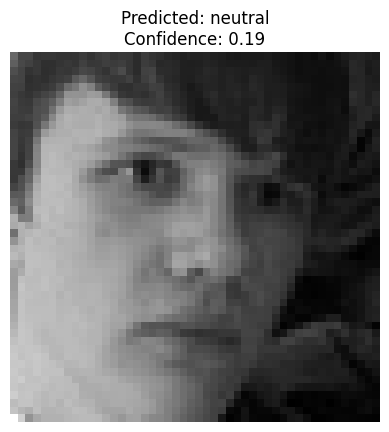

Probabilities for each class:
angry: 0.1162
disgust: 0.1646
fear: 0.1323
happy: 0.1789
neutral: 0.1888
sad: 0.1369
surprise: 0.0824


In [99]:
# Define the category labels
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def predict_expression(image_path, model):
    # Load and preprocess the image
    img = Image.open(image_path).convert('L')  # Convert image to grayscale
    img = img.resize((46, 46))  # Resize to match the model's expected input shape
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize if required

    # Make predictions
    predictions = model.predict(img_array)
    
    # Get the index of the maximum value (predicted class)
    predicted_class_index = np.argmax(predictions[0])
    
    # Map the index to the category label
    predicted_category = categories[predicted_class_index]
    
    # Get the confidence of the prediction
    confidence = predictions[0][predicted_class_index]
    
    # Load the image for display
    img_display = Image.open(image_path)
    
    # Display the image and prediction
    plt.imshow(img_display, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {predicted_category}\nConfidence: {confidence:.2f}")
    plt.show()
    
    # Print the probabilities for each class
    print("Probabilities for each class:")
    for class_name, prob in zip(categories, predictions[0]):
        print(f"{class_name}: {prob:.4f}")

# Example usage:
# Assuming you have loaded your model
# model = tf.keras.models.load_model('expression_classification_model.keras')
predict_expression('./face-expression-recognition-dataset/images/images/validation/sad/17666.jpg', loaded_model)


#### test with random image from the validation dataset

Chosen image path: ./face-expression-recognition-dataset/images/images/validation/happy/18834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


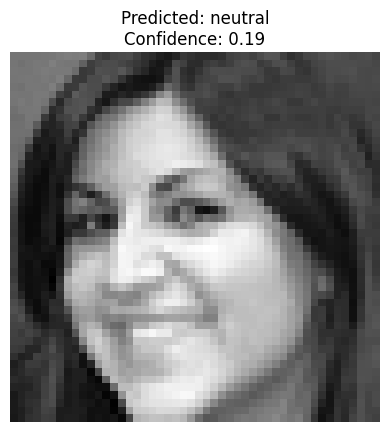

Probabilities for each class:
angry: 0.1167
disgust: 0.1640
fear: 0.1289
happy: 0.1881
neutral: 0.1935
sad: 0.1426
surprise: 0.0661


In [104]:
# Define the category labels
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def predict_expression(image_path, model):
    # Load and preprocess the image
    img = Image.open(image_path).convert('L')  # Convert image to grayscale
    img = img.resize((46, 46))  # Resize to match the model's expected input shape
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize if required

    # Make predictions
    predictions = model.predict(img_array)
    
    # Get the index of the maximum value (predicted class)
    predicted_class_index = np.argmax(predictions[0])
    
    # Get the predicted category
    predicted_category = categories[predicted_class_index]
    
    # Get the confidence of the prediction
    confidence = predictions[0][predicted_class_index]
    
    # Load the image for display
    img_display = Image.open(image_path)
    
    # Display the image and prediction
    plt.imshow(img_display, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {predicted_category}\nConfidence: {confidence:.2f}")
    plt.show()
    
    # Print the probabilities for each class
    print("Probabilities for each class:")
    for class_name, prob in zip(categories, predictions[0]):
        print(f"{class_name}: {prob:.4f}")
    
    return predicted_category, confidence

def get_random_image_path(base_dir):
    # Get all subdirectories (categories)
    categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    # Choose a random category
    random_category = random.choice(categories)
    
    # Get all image files in the chosen category
    category_path = os.path.join(base_dir, random_category)
    image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
    
    # Choose a random image file
    random_image = random.choice(image_files)
    
    return os.path.join(category_path, random_image)

# Directory containing the images
base_dir = './face-expression-recognition-dataset/images/images/validation/'

# Choose a random image
random_image_path = get_random_image_path(base_dir)

# Print the path of the chosen image
print(f"Chosen image path: {random_image_path}")

# Load the model
# Replace 'expression_classification_model.keras' with your model file path
loaded_model = tf.keras.models.load_model('expression_classification_model.keras')

# Make a prediction
predicted_category, confidence = predict_expression(random_image_path, loaded_model)